<a href="https://www.kaggle.com/code/gemmin/speech-emotion-recognition-90?scriptVersionId=259804048" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. EDA
3. Preprocess
4. Extract features
5. Build LSTM
6. Evaluate

Datasets:
* Crema-D
* Ravdess
* Savee
* Tessa
* EmoDB

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random

os.environ['PYTHONHASHSEED'] = '1'
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
EMODB = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_directory_list = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        code = part.split('-')[2]
        if code in code_to_emotion:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(code_to_emotion[code])
            
ravdess = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess.head()

path     sex  emotion
0  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
1  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
2  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
3  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
4  /kaggle/input/ravdess-emotional-speech-audio/a...  female     fear

**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_directory_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_set = {
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
}

for audio_file in crema_directory_list:
    part = audio_file.split('_')
    code = part[2]
    if code in code_to_emotion and part[3] == 'HI.wav': # Could try curriculum learning. 
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_set else 'male')
        emotion_list.append(code_to_emotion[code])

crema = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema.head()

path     sex  emotion
0  /kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav    male    happy
1  /kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav  female     fear
2  /kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav  female    angry
3  /kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav    male      sad
4  /kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav  female  disgust

**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

code_to_emotion = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust' : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        code = part.split('_')[2]
        if code in code_to_emotion:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(code_to_emotion[code])
            
tess = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess.head()

path     sex emotion
0  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
1  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
2  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
3  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
4  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear

**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_directory_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_directory_list:
    part = audio_file.split('_')[1]
    code = part[:-6]
    if code in code_to_emotion:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(code_to_emotion[code])
        
savee = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee.head()

path   sex  emotion
0  /kaggle/input/surrey-audiovisual-expressed-emo...  male    happy
1  /kaggle/input/surrey-audiovisual-expressed-emo...  male     fear
2  /kaggle/input/surrey-audiovisual-expressed-emo...  male    happy
3  /kaggle/input/surrey-audiovisual-expressed-emo...  male  disgust
4  /kaggle/input/surrey-audiovisual-expressed-emo...  male    angry

**5. EmoDB Dataframe**

There are 535 audio files, for example, 03a01**F**a.wav.

In [7]:
emodb_directory_list = os.listdir(EMODB)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    'W' : 'angry',
    'E' : 'disgust', 
    'A' : 'fear', 
    'F' : 'happy', 
    'T' : 'sad', 
    'N' : 'neutral'
}

female_id_set = {
    '08', '09', '13', '14', '16'
}

print(emodb_directory_list[0].split('.')[0][0:2])

for audio_file in emodb_directory_list:
    part = audio_file.split('.')[0]
    code = part[-2]
    if code in code_to_emotion: 
        path_list.append(f"{EMODB}{audio_file}")
        gender_list.append('female' if part[0:2] in female_id_set else 'male')
        emotion_list.append(code_to_emotion[code])

emodb = pd.concat([
    pd.DataFrame(path_list, columns=['path']), 
    pd.DataFrame(gender_list, columns=['sex']), 
    pd.DataFrame(emotion_list, columns=['emotion']), 
], axis=1)

emodb.head()

15


path     sex emotion
0  /kaggle/input/berlin-database-of-emotional-spe...    male   happy
1  /kaggle/input/berlin-database-of-emotional-spe...  female   happy
2  /kaggle/input/berlin-database-of-emotional-spe...  female   angry
3  /kaggle/input/berlin-database-of-emotional-spe...    male   angry
4  /kaggle/input/berlin-database-of-emotional-spe...  female   angry

In [8]:
df = pd.concat([
    ravdess, 
    crema, 
    tess, 
    savee, 
    emodb
], axis=0)
df.head()

path     sex  emotion
0  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
1  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
2  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
3  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
4  /kaggle/input/ravdess-emotional-speech-audio/a...  female     fear

# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [9]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [10]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 0 to 453
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     4785 non-null   object
 1   sex      4785 non-null   object
 2   emotion  4785 non-null   object
dtypes: object(3)
memory usage: 149.5+ KB


path     sex  emotion
0  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
1  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
2  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
3  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
4  /kaggle/input/ravdess-emotional-speech-audio/a...  female     fear

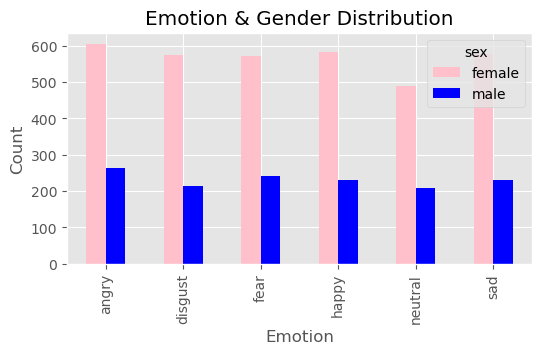

In [11]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion & Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

Slight imbalances, but I think we have enough data. Let's see some sample data. 

In [12]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

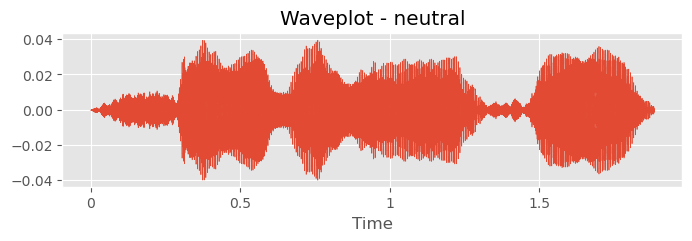

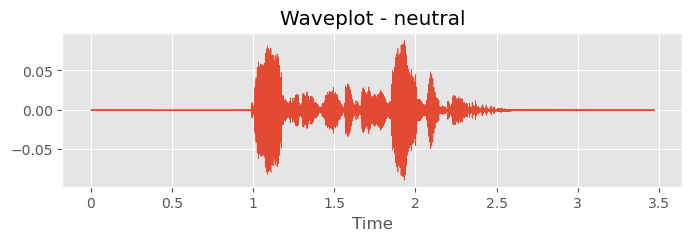

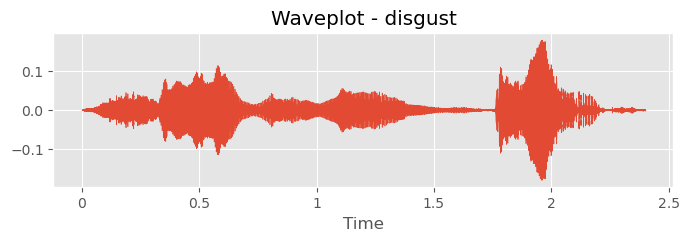

In [13]:
sample_size = 3
sample = df.sample(n=sample_size, random_state=1)

for idx, row in sample.iterrows():
   emotion = row['emotion']
   path = row['path']
   
   y, sr = librosa.load(path)
   create_waveplot(y, sr, f"Waveplot - {emotion}")
   
   display(Audio(path))
   print("\n")

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Sample Rate
2. Trimming  
3. Padding

In [14]:
from pydub import AudioSegment, effects

In [15]:
def preprocess_audio(path):
    _, sr = librosa.load(path) # default sample rate is 22 050 hz
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = trimmed[:180000] if len(trimmed) > 180000 else np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

The audio will be around 8 seconds. Most speech samples are 2-4 seconds, so typically we're adding around 4-6 seconds of silence (which we will see later). 

In [16]:
emotion_to_code = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

code_to_emotion = {v : k for k, v in emotion_to_code.items()}

def encode(label):
    return emotion_to_code.get(label)

def decode(encoded_label):
    return code_to_emotion.get(encoded_label) 

# 4. Extract features

We extract three features, using librosa (https://librosa.org/doc/latest/index.html):

1. Mel-Frequency Cepstral Coefficients (MFCC)
2. Zero Crossing Rate (ZCR)
3. Root Mean Square Energy (RMS)

But, before that, we should look at the hop length & the frame length. 

In [17]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

The hop length is set to 512 samples & the frame length is set to 2048 samples for consistency. The hop length is the size of the sliding window. Think of it as taking a "snapshot." The frame length is how many samples you "jump" forward between each window. In the diagram below:

* HOP_LENGTH: Q
* FRAME_LENGTH: K

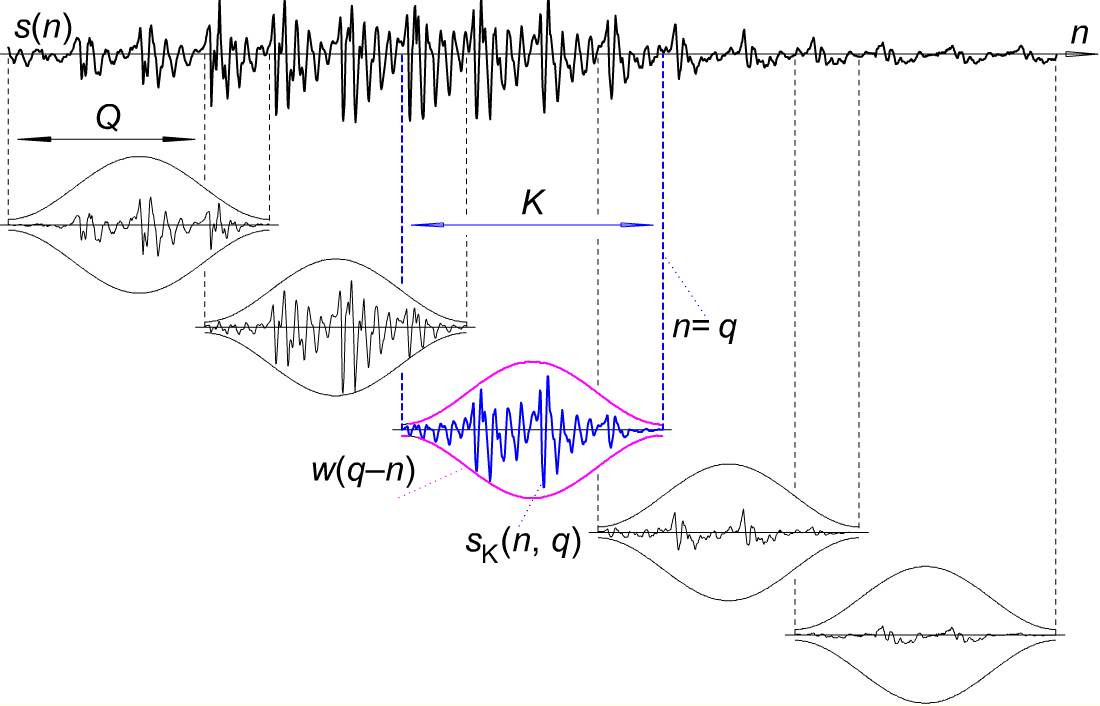

In [18]:
sample_idx = 0 # look at other samples :)
y, sr = preprocess_audio(df.iloc[sample_idx]['path'])
emotion = df.iloc[sample_idx]['emotion']

**1. Mel-Frequency Cepstral Coefficients (MFCC)**

They capture the spectral structure. The extraction process involves windowing the signal, applying the Fourier transform, mapping the power spectrum onto the perceptually-motivated mel scale, taking the logarithm to create the mel spectrogram, & finally computing the discrete cosine transform (DCT) to decorrelate the coefficients into the MFCC representation used by the model. The visualization below shows both the mel spectrogram & the MFCCs, but only the 13 MFCC coefficients are used as input features.

$\text{MFCC}_n = \sum_{k=1}^{K} \log(S_k) \cos\left[ n \left( k - \frac{1}{2} \right) \frac{\pi}{K} \right]$

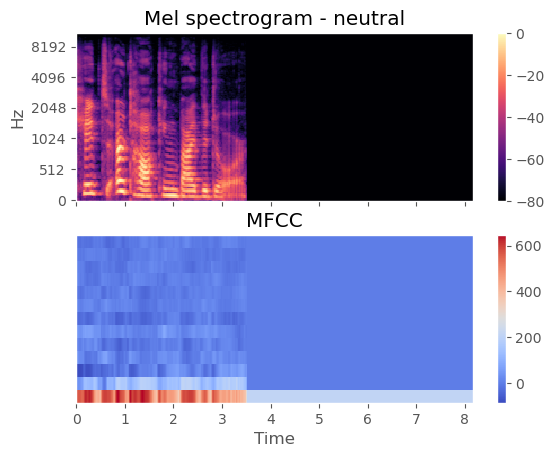

In [19]:
S = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

fig, ax = plt.subplots(nrows=2, sharex=True)

img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title=f'Mel spectrogram - {emotion}')
ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')
plt.show()

**2. Zero Crossing Rate**

It measures how often the audio signal crosses zero amplitude. High ZCR means more noisy or hiss-like sounds; low ZCR means smoother, voiced sounds like vowels. This means ZCR can tell how "harsh" or "smooth," which is commonly associated with the emotion digust.  

$\text{ZCR} = \frac{1}{2N} \sum_{n=0}^{N-1} \left| \text{sgn}(x[n]) - \text{sgn}(x[n-1]) \right|$


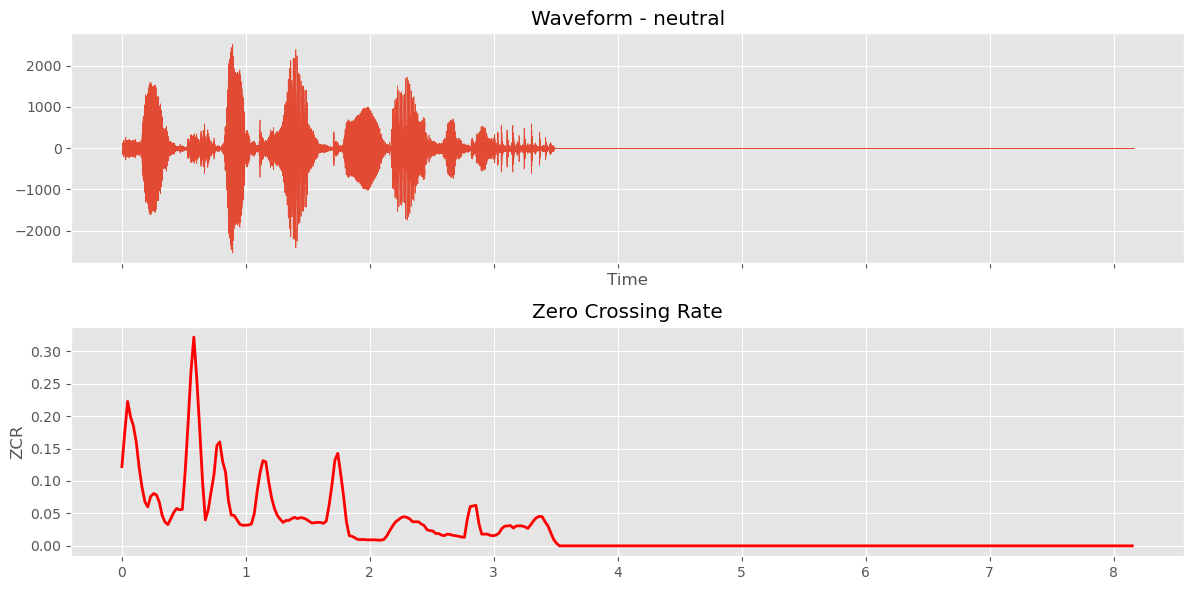

In [20]:
zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
times = librosa.frames_to_time(np.arange(len(zcr)), sr=sr, hop_length=HOP_LENGTH)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title=f'Waveform - {emotion}')
ax[1].plot(times, zcr, color='red', linewidth=2)
ax[1].set(title='Zero Crossing Rate', ylabel='ZCR')
plt.tight_layout()
plt.show()

**3. Root Mean Squared** 

They measure the average energy or loudness. High RMS values indicate loud, energetic speech segments, while low values correspond to quiet or whispered speech. Thus, they help distinguish between high-energy emotions like anger or happy (high RMS) vs. low-energy emotions like sadness or neutral (low RMS). 

$\text{RMS} = \sqrt{\frac{1}{N} \sum_{n=0}^{N-1} x[n]^2}$

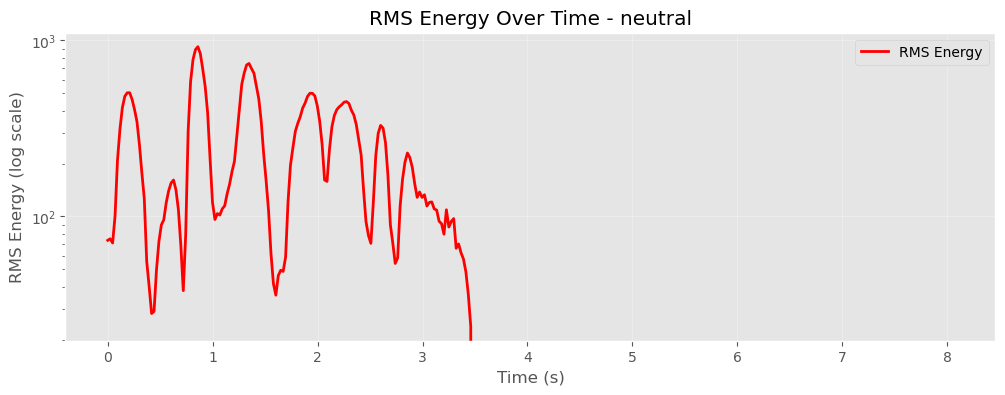

In [21]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))[0]
rms = librosa.feature.rms(S=S)
times = librosa.times_like(rms)

plt.figure(figsize=(12, 4))
plt.semilogy(times, rms[0], label='RMS Energy', color='red', linewidth=2)
plt.title(f'RMS Energy Over Time - {emotion}')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Shape of $X$: (samples, timesteps, features)
* samples: number of audio files
* timesteps: number of frames = 1 + floor(len(y) / HOP_LENGTH) = 352
* features: [zcr, rms, mfcc_1, mfcc_2, ..., mfcc_13] (total 15 features)

In [22]:
def extract_features(df):
    zcr_list = []
    rms_list = []
    mfccs_list = []
    emotion_list = []
    
    for row in df.itertuples(index=False):
        try: 
            y, sr = preprocess_audio(row.path)
    
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
    
            zcr_list.append(zcr)
            rms_list.append(rms)
            mfccs_list.append(mfccs)
    
            emotion_list.append(encode(row.emotion))
        except Exception as e:
            print(f"Failed for path: {row.path}")
            print(f"Error: {e}")
    
    X = np.concatenate((
        np.swapaxes(zcr_list, 1, 2), 
        np.swapaxes(rms_list, 1, 2), 
        np.swapaxes(mfccs_list, 1, 2)), 
        axis=2
    )
    X = X.astype('float32')
    
    y = np.asarray(emotion_list)
    y = np.expand_dims(y, axis=1).astype('int8')

    return X, y

In terms of sex count, we have a imbalanced dataset. Furthermore, differences between sexes are biologically & behaviourally plausible, thus, I will create two models (1 male & 1 female). 

In [23]:
df_female = df[df.sex == 'female'].copy()
df_male = df[df.sex == 'male'].copy()

In [24]:
X_female, y_female = extract_features(df_female)
X_male, y_male = extract_features(df_male)

In [25]:
print("Female: ")
print(X_female.shape)
print(y_female.shape)

print("Male: ")
print(X_male.shape)
print(y_male.shape)

Female: 
(3399, 352, 15)
(3399, 1)
Male: 
(1386, 352, 15)
(1386, 1)


Let's create a radar plot to validate these features, seeing how spectral & temporal patterns correlation with various emotions.

In [26]:
def extract_means(X, y):
    sample_means = np.mean(X, axis=1)
    feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 14)]
    df = pd.DataFrame(sample_means, columns=feature_names)
    df['emotion'] = [decode(emotion_code) for emotion_code in y.flatten()]

    return df

df_female_means = extract_means(X_female, y_female)
df_male_means = extract_means(X_male, y_male)

print("Female Means DF: ")
print(df_female_means.head())

print("Male Means DF: ")
print(df_male_means.head())

Female Means DF: 
        ZCR         RMS       MFCC1      MFCC2      MFCC3      MFCC4  \
0  0.024746  105.464600  341.499054  60.648106   0.453078   6.618733   
1  0.038538  202.757462  435.621185  66.627693  -4.630603  11.763195   
2  0.028080   89.618889  329.838989  63.908962  -5.549635  10.375246   
3  0.030774  167.918198  392.446991  60.254528   1.747526   7.338648   
4  0.039638  560.247681  497.415894  38.340744 -13.715072   4.085318   

      MFCC5      MFCC6      MFCC7     MFCC8     MFCC9    MFCC10    MFCC11  \
0 -1.448189  10.790609  -7.324445  2.443778 -1.125623  0.590647 -2.630092   
1  2.102120   7.215371  -8.628454 -0.264839 -0.279486  2.216101 -3.050270   
2  2.407283   7.663542  -6.799921  2.485309  0.151874  1.985165 -2.556408   
3 -1.996967   9.588508  -7.774040  1.245252 -1.627656  0.225617 -2.658981   
4 -9.474839   6.421329 -10.930285 -4.409543 -4.861330 -2.544556 -7.696184   

     MFCC12    MFCC13  emotion  
0 -2.663263 -2.021348  neutral  
1 -1.429288 -1.92360

Let's use a simple boxplot to identify outliers, but note simple IQR tests may be insufficient since we are assuming normal distributions. We could manually investigate these outliers. 

Female: 
n = 3399
Feature: ZCR. Outlier Count: 53
Feature: RMS. Outlier Count: 203
Feature: MFCC1. Outlier Count: 35
Feature: MFCC2. Outlier Count: 333
Feature: MFCC3. Outlier Count: 30
Feature: MFCC4. Outlier Count: 51


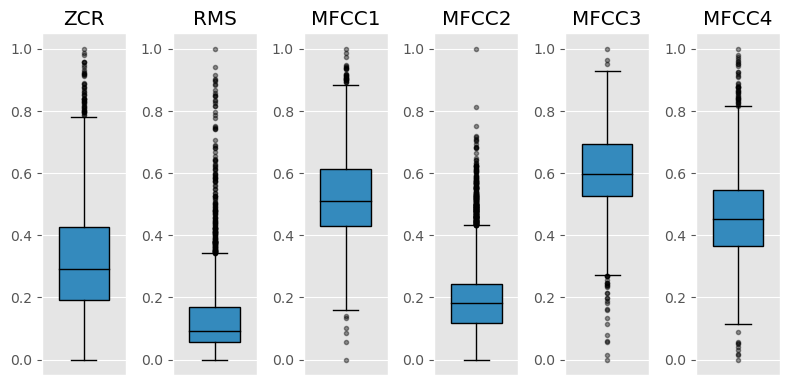

Male: 
n = 1386
Feature: ZCR. Outlier Count: 36
Feature: RMS. Outlier Count: 122
Feature: MFCC1. Outlier Count: 0
Feature: MFCC2. Outlier Count: 0
Feature: MFCC3. Outlier Count: 93
Feature: MFCC4. Outlier Count: 2


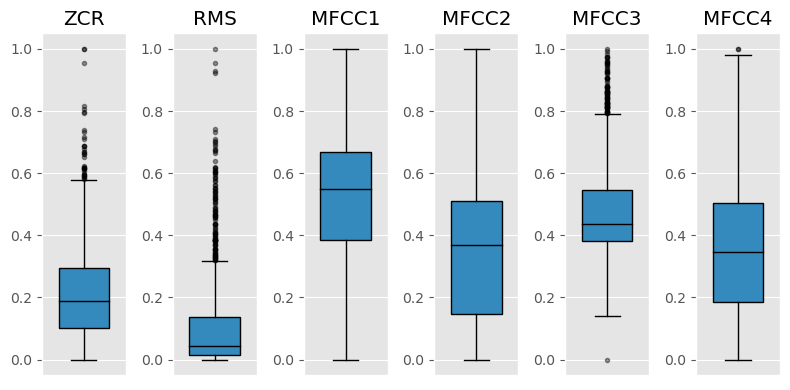

In [27]:
from sklearn.preprocessing import MinMaxScaler

def identify_outliers(df):
    print(f'n = {len(df)}')
    
    feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 5)]

    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df[feature_names]), columns=feature_names, index=df.index)

    n = len(feature_names)
    fig, axs = plt.subplots(1, n, figsize=(8, 4)) 

    for i in range(n):
        feature_name = feature_names[i]
        
        Q1 = df[feature_name].quantile(0.25)
        Q3 = df[feature_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_mask = (df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)
        print(f'Feature: {feature_name}. Outlier Count: {outlier_mask.sum()}')
        
        axs[i].boxplot(
            df[feature_name], 
            patch_artist=True, 
            widths=0.6, 
            medianprops=dict(color='black'), 
            flierprops=dict(markerfacecolor='black', marker='o', markersize=3, alpha=0.4)
        )
        axs[i].set_title(feature_name)
        axs[i].set_xticks([])

    plt.tight_layout()
    plt.show()

print("Female: ")
identify_outliers(df_female_means)

print("Male: ")
identify_outliers(df_male_means)

MFCC2 for females warrants an investigation.

Females: 


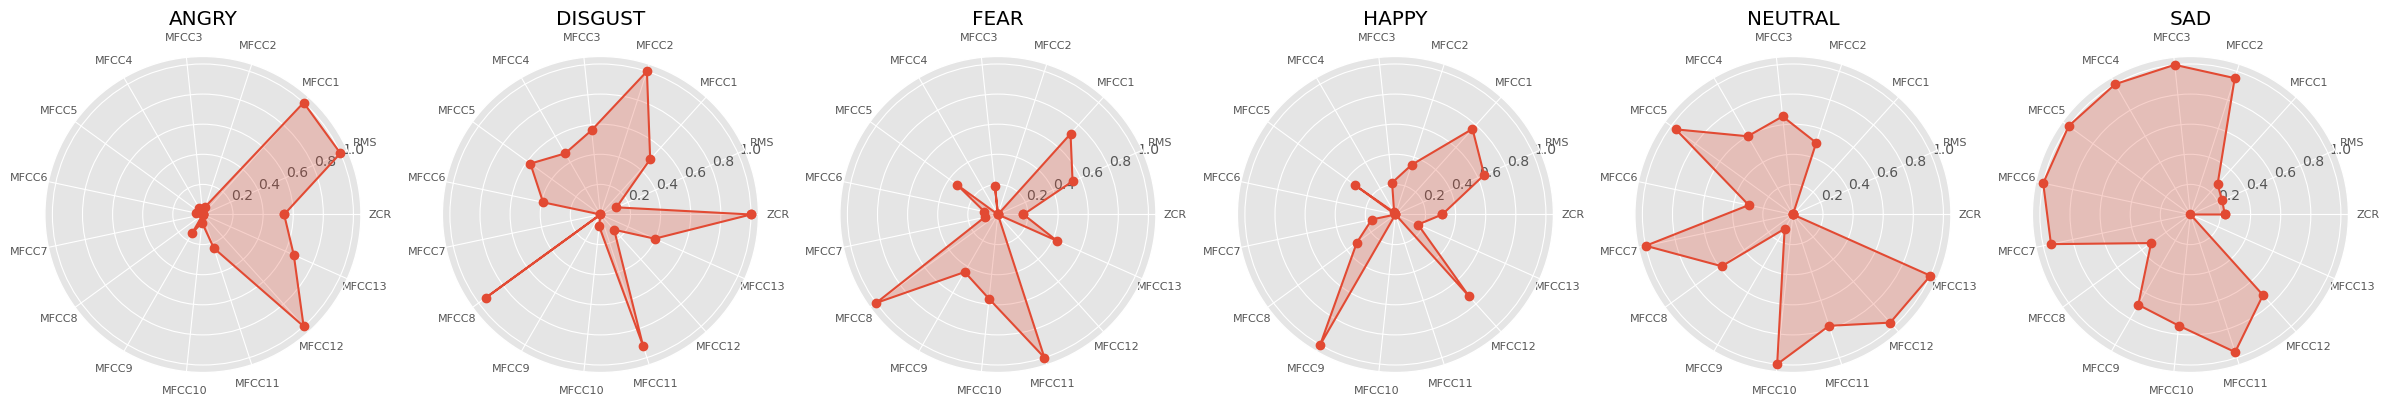

Males: 


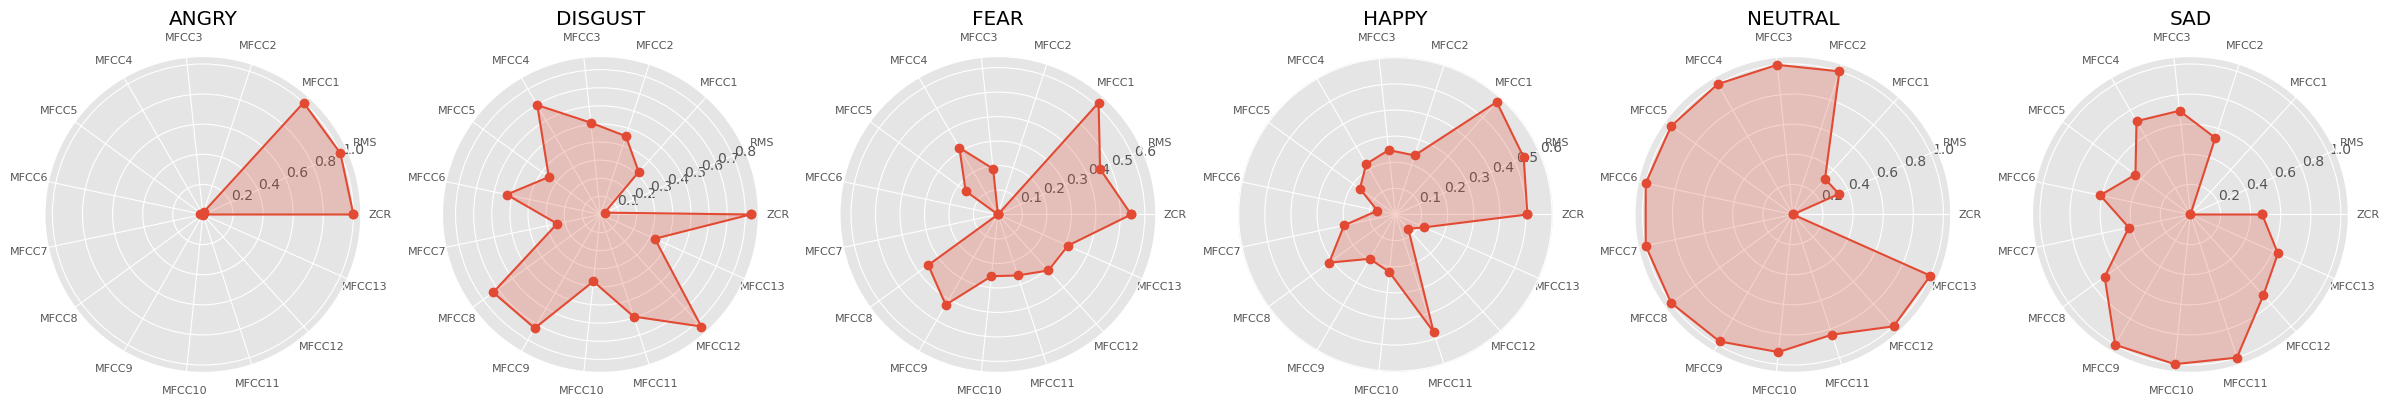

In [28]:
def radar_plot(df):
    means = df.groupby('emotion').mean()
    scaler = MinMaxScaler()
    normalized = pd.DataFrame(scaler.fit_transform(means), index=means.index, columns=means.columns)
    
    n = len(normalized)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4), subplot_kw={'polar': True})
    
    angles = np.append(np.linspace(0, 2*np.pi, len(normalized.columns), False), 0)
    
    for i, (emotion, row) in enumerate(normalized.iterrows()):
        vals = np.append(row.values, row.values[0])
        axs[i].plot(angles, vals, 'o-')
        axs[i].fill(angles, vals, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(normalized.columns, fontsize=8)
        axs[i].set_title(emotion.upper())
    
    plt.tight_layout()
    plt.show()

print("Females: ")
radar_plot(df_female_means)

print("Males: ")
radar_plot(df_male_means)

We can see many patterns: 
* High-energy emotions like angry is associated with high RMS, ZCR & MFCC1. 
* Calm emotions like neutral & sad emotions result with lower RMS & ZCR.
* ZCR seems to be a strong indicator for disgust.
* Females show the most distinctive spectral patterns in sad speech (high mfccs).
* So on ...

The most important observation is that we probably will not be able to get the same performance for the male model in comparison to the female model. Let's see if any of these differences in means are significant using the Kruskal test, since distributions are probably not normal (from boxplots).

In [29]:
from scipy.stats import mannwhitneyu

feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 14)]

for feature_name in feature_names:
    _, p = mannwhitneyu(df_female_means[feature_name], df_male_means[feature_name])
    print(f'Feature: {feature_name}. p-value: {p}')

Feature: ZCR. p-value: 5.599245597081187e-170
Feature: RMS. p-value: 1.706169678466896e-39
Feature: MFCC1. p-value: 6.307735307006657e-51
Feature: MFCC2. p-value: 2.059495968034315e-202
Feature: MFCC3. p-value: 3.3650409719552624e-23
Feature: MFCC4. p-value: 8.409896649033506e-160
Feature: MFCC5. p-value: 6.602768836540658e-11
Feature: MFCC6. p-value: 1.7908748377199304e-160
Feature: MFCC7. p-value: 8.966181029694953e-163
Feature: MFCC8. p-value: 4.2433067979393006e-191
Feature: MFCC9. p-value: 6.8522057124644176e-189
Feature: MFCC10. p-value: 3.859164806554442e-60
Feature: MFCC11. p-value: 0.0
Feature: MFCC12. p-value: 2.908960720297613e-24
Feature: MFCC13. p-value: 0.0012370369971430547


# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences. We will first create the female model. 

In [30]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [31]:
def create_model():
    MODEL = Sequential()
    MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=((352, 15))))
    MODEL.add(layers.LSTM(64))
    MODEL.add(layers.Dense(6, activation='softmax'))
    
    return MODEL 

model_female = create_model()
print("Female: ")
print(model_female.summary())

model_male = create_model()
print("Male: ")
print(model_male.summary())

Female: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None
Male: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 352, 64)           20480     
                                                                 
 lstm_3 (

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint 

In [33]:
def train(X, y, model, epochs, model_name):
    X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)
    
    y_train_class = to_categorical(y_train, 6)
    y_val_class = to_categorical(y_val, 6)

    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train), 
        y=y_train.flatten()
    )

    checkpoint = ModelCheckpoint(
        model_name, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
    )
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='RMSProp',
        metrics=['categorical_accuracy']
    )
    
    history = model.fit(
        X_train, 
        y_train_class, 
        epochs=epochs, 
        batch_size=6, 
        validation_data=(X_val, y_val_class), 
        class_weight=dict(enumerate(class_weights)), 
        # callbacks=checkpoint
    )

    return history, X_val, y_val

In [34]:
history_female, X_val_female, y_val_female = train(X_female, y_female, model_female, 200, 'model_female.h5')

Epoch 1/200
499/499 [==============================] - 18s 19ms/step - loss: 1.6424 - categorical_accuracy: 0.2905 - val_loss: 1.5935 - val_categorical_accuracy: 0.3228
Epoch 2/200
499/499 [==============================] - 9s 17ms/step - loss: 1.4602 - categorical_accuracy: 0.3848 - val_loss: 1.5418 - val_categorical_accuracy: 0.3579
Epoch 3/200
499/499 [==============================] - 9s 17ms/step - loss: 1.3648 - categorical_accuracy: 0.4407 - val_loss: 1.3288 - val_categorical_accuracy: 0.4211
Epoch 4/200
499/499 [==============================] - 9s 18ms/step - loss: 1.3308 - categorical_accuracy: 0.4493 - val_loss: 1.4558 - val_categorical_accuracy: 0.3965
Epoch 5/200
499/499 [==============================] - 9s 18ms/step - loss: 1.3019 - categorical_accuracy: 0.4600 - val_loss: 1.2849 - val_categorical_accuracy: 0.4807
Epoch 6/200
499/499 [==============================] - 9s 18ms/step - loss: 1.2788 - categorical_accuracy: 0.4794 - val_loss: 1.3159 - val_categorical_accuracy

In [35]:
history_male, X_val_male, y_val_male = train(X_male, y_male, model_male, 95, 'model_male.h5')

Epoch 1/95
204/204 [==============================] - 8s 23ms/step - loss: 1.7639 - categorical_accuracy: 0.2133 - val_loss: 1.7392 - val_categorical_accuracy: 0.2845
Epoch 2/95
204/204 [==============================] - 4s 19ms/step - loss: 1.7170 - categorical_accuracy: 0.2600 - val_loss: 1.6622 - val_categorical_accuracy: 0.2586
Epoch 3/95
204/204 [==============================] - 4s 19ms/step - loss: 1.6864 - categorical_accuracy: 0.2724 - val_loss: 1.6963 - val_categorical_accuracy: 0.2241
Epoch 4/95
204/204 [==============================] - 4s 19ms/step - loss: 1.6728 - categorical_accuracy: 0.2929 - val_loss: 1.6256 - val_categorical_accuracy: 0.2759
Epoch 5/95
204/204 [==============================] - 4s 19ms/step - loss: 1.6432 - categorical_accuracy: 0.3109 - val_loss: 1.5682 - val_categorical_accuracy: 0.3534
Epoch 6/95
204/204 [==============================] - 4s 19ms/step - loss: 1.6034 - categorical_accuracy: 0.3331 - val_loss: 1.5954 - val_categorical_accuracy: 0.293

# 6. Evaluate and conclude

Let's see how good are model is. 

Females: 


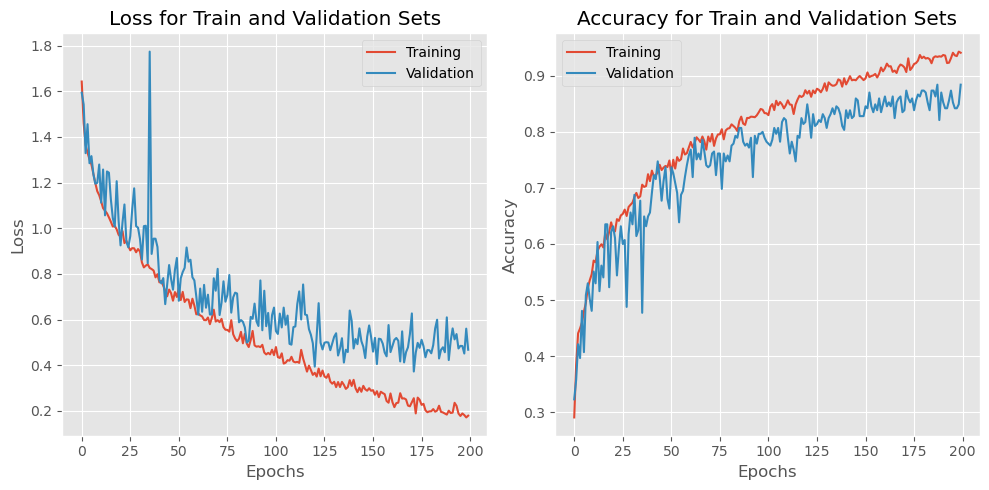

Males: 


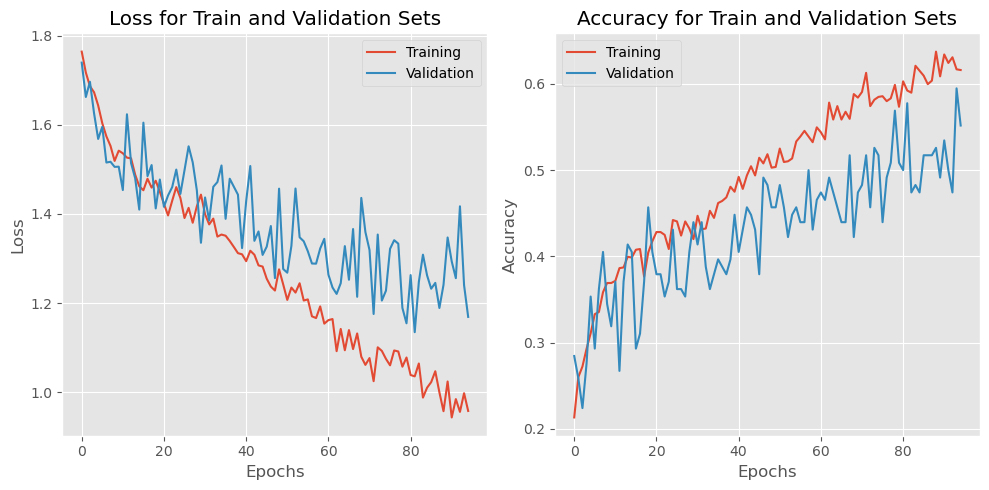

In [36]:
def create_training_history_plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Loss for Train and Validation Sets')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['Training', 'Validation'])
    
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].set_title('Accuracy for Train and Validation Sets')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['Training', 'Validation'])
    
    fig.tight_layout()
    
    plt.show()

print("Females: ")
create_training_history_plot(history_female)

print("Males: ")
create_training_history_plot(history_male)

We for sure need more male data. 

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

9/9 [==============================] - 1s 18ms/step


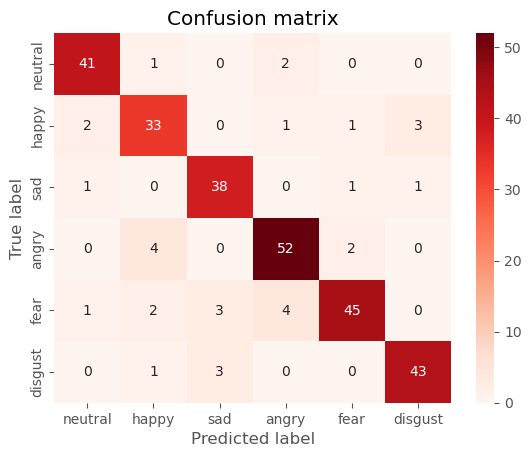

4/4 [==============================] - 1s 11ms/step


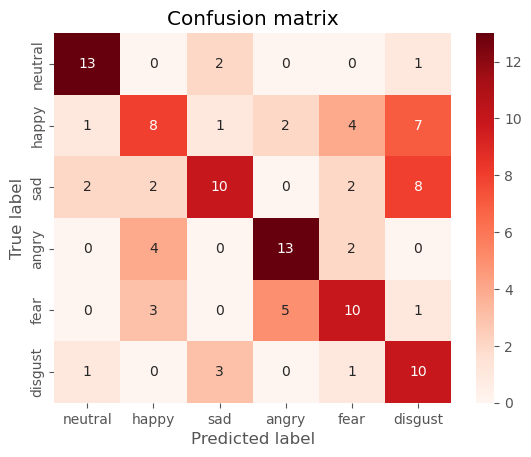

In [38]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'] 

def create_confusion_matrix(model, X_val, y_val):
    features = model.predict(X_val)
    y_val_class = to_categorical(y_val, 6)
    y_pred = np.argmax(features, axis=1)
    y_true = np.argmax(y_val_class, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=range(6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()


create_confusion_matrix(model_female, X_val_female, y_val_female)
create_confusion_matrix(model_male, X_val_male, y_val_male)

In [39]:
def create_classification_report(model, X_val, y_val):
    features = model.predict(X_val)
    y_val_class = to_categorical(y_val, 6)
    y_pred = np.argmax(features, axis=1)
    y_true = np.argmax(y_val_class, axis=1)
    
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.round(3))

print("Female: ")
create_classification_report(model_female, X_val_female, y_val_female)

print("Male: ")
create_classification_report(model_male, X_val_male, y_val_male)

Female: 
9/9 [==============================] - 0s 18ms/step
              precision  recall  f1-score  support
neutral           0.911   0.932     0.921   44.000
happy             0.805   0.825     0.815   40.000
sad               0.864   0.927     0.894   41.000
angry             0.881   0.897     0.889   58.000
fear              0.918   0.818     0.865   55.000
disgust           0.915   0.915     0.915   47.000
accuracy          0.884   0.884     0.884    0.884
macro avg         0.882   0.886     0.883  285.000
weighted avg      0.885   0.884     0.884  285.000
Male: 
4/4 [==============================] - 0s 12ms/step
              precision  recall  f1-score  support
neutral           0.765   0.812     0.788   16.000
happy             0.471   0.348     0.400   23.000
sad               0.625   0.417     0.500   24.000
angry             0.650   0.684     0.667   19.000
fear              0.526   0.526     0.526   19.000
disgust           0.370   0.667     0.476   15.000
accuracy     

**Conclusion**

In summary, we got around 90% accuracy for females & around 60% accuracy for males. In theory, if we have more data for males, we should be able to get reasonable accuracy. Please help me by upvoting :). 